### **Connect Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Load Dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hayammostafa","key":"1bb4ad4704e1bdec4c21c16d08d4daae"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


### **Imports**

In [1]:
import re
import pickle
import pandas as pd
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### **Information Dataset**

In [6]:
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")

In [7]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
df.shape

(50000, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### **EDA**

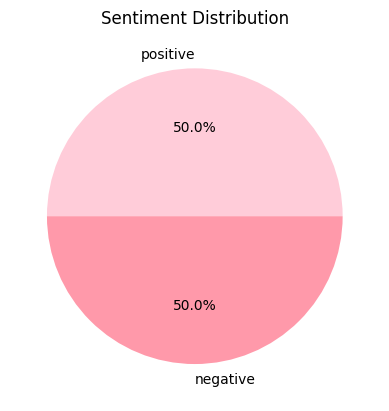

In [10]:
sentiment_counts = df['sentiment'].value_counts()
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', colors= ['#ffccd9', '#ff99aa'] )
plt.title("Sentiment Distribution")
plt.show()

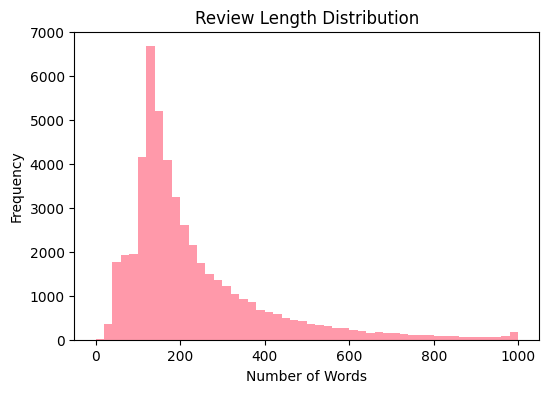

In [11]:
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6,4))
plt.hist(df['review_length'], bins=50, range=(0,1000), color='#ff99aa')
plt.title("Review Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

### **Preprocessing**

In [12]:
df.isnull().sum()

,0
review,0
sentiment,0
review_length,0


In [13]:
print(df.duplicated().sum())

418


In [14]:
df.drop_duplicates(inplace=True)

In [15]:
def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [16]:
df['review'] = df['review'].apply(clean_text)

In [17]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df.drop('sentiment', axis=1, inplace=True)

In [18]:
df.head()

,review,review_length,label
0,one of the other reviewers has mentioned that ...,307,1
1,a wonderful little production the filming tech...,162,1
2,i thought this was a wonderful way to spend ti...,166,1
3,basically there s a family where a little boy ...,138,0
4,petter mattei s love in the time of money is a...,230,1


### **Tokenization**

In [19]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['review'])

sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, maxlen=200)
labels = df['label'].values

In [20]:
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

### **Split Train and Test**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42, stratify=labels)

### **Train Model**

In [22]:
model = Sequential()
model.add(Embedding(input_dim=10001, output_dim=128, input_length=200))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train,epochs=10,batch_size=64,validation_split=0.1,callbacks=[early_stop],verbose=1)

Epoch 1/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 398s 702ms/step - accuracy: 0.7176 - loss: 0.5389 - val_accuracy: 0.8293 - val_loss: 0.4082
Epoch 2/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 434s 688ms/step - accuracy: 0.8620 - loss: 0.3414 - val_accuracy: 0.8636 - val_loss: 0.3318
Epoch 3/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 448s 698ms/step - accuracy: 0.8633 - loss: 0.3276 - val_accuracy: 0.8689 - val_loss: 0.3309
Epoch 4/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 442s 698ms/step - accuracy: 0.9060 - loss: 0.2420 - val_accuracy: 0.8651 - val_loss: 0.3434
Epoch 5/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 392s 702ms/step - accuracy: 0.9259 - loss: 0.1974 - val_accuracy: 0.8596 - val_loss: 0.3599
Epoch 6/10
558/558 ━━━━━━━━━━━━━━━━━━━━ 392s 703ms/step - accuracy: 0.9325 - loss: 0.1781 - val_accuracy: 0.8752 - val_loss: 0.3462


In [24]:
model.save("/content/drive/MyDrive/LSTM_imdb_model.h5")
with open("/content/drive/MyDrive/LSTM_imdb_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [27]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/LSTM_imdb_model.h5")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     1,280,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,411,843 (5.39 MB)

 Trainable params: 1,411,841 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

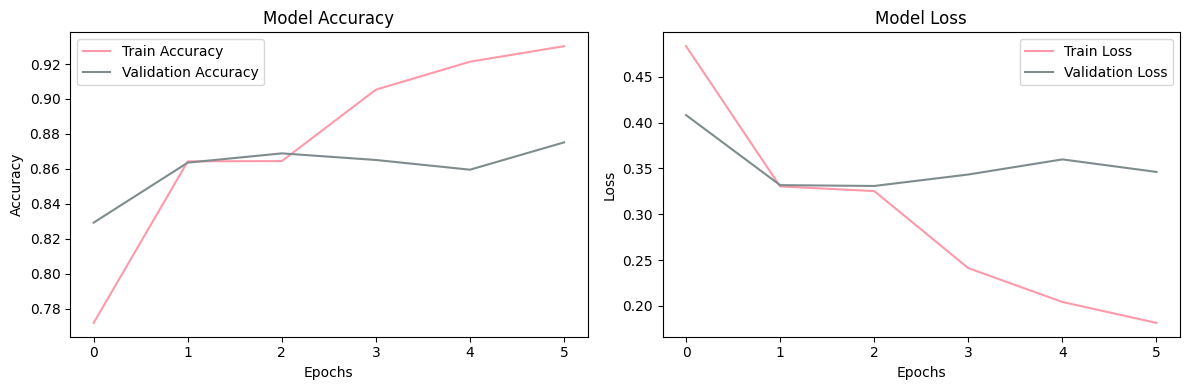

In [34]:
with open("/content/drive/MyDrive/LSTM_imdb_history.pkl", "rb") as f:
    history = pickle.load(f)
colors = ['#ff99aa', '#7f8c8d']  # بينك فاتح + رمادي متوسط

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], color=colors[0], label='Train Accuracy')
plt.plot(history['val_accuracy'], color=colors[1], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], color=colors[0], label='Train Loss')
plt.plot(history['val_loss'], color=colors[1], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

### **Evaluation**

In [35]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 109ms/step
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      4940
           1       0.86      0.88      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



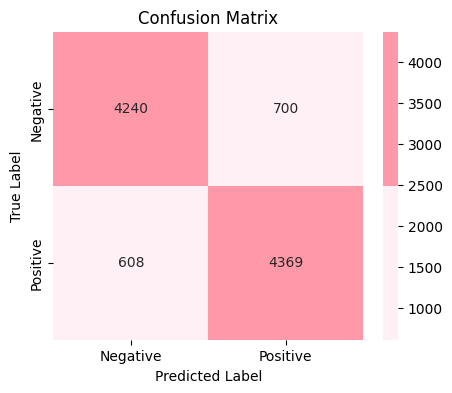

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm,annot=True,fmt='d',cmap=["#fff0f5", "#ff99aa"],xticklabels=['Negative', 'Positive'],yticklabels=['Negative', 'Positive'])

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **GUI**

In [44]:
!pip install --quiet streamlit pyngrok tensorflow keras bs4 pillow
from pyngrok import ngrok
ngrok.kill()

In [45]:
ngrok.set_auth_token("30U2HAlJQbZebe7blq2x3NNyeJT_23d7hk7aPcVwQEHGzeeLf")

app_code = """
import streamlit as st
import pickle, re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/LSTM_imdb_model.h5")
with open("/content/drive/MyDrive/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

def clean_text(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = re.sub(r'\\s+', ' ', text).strip()
    return text

st.set_page_config(
    page_title="Movie Sentiment Analyzer",
    page_icon="🎬",
    layout="centered"
)

st.markdown('''
<div style="display:flex; justify-content:center; margin-top:10px;">
    <div style="
        background: linear-gradient(135deg, #667eea, #764ba2);
        width:90px;
        height:90px;
        border-radius:24px;
        display:flex;
        align-items:center;
        justify-content:center;
        font-size:42px;
        box-shadow: 0px 10px 25px rgba(102,126,234,0.4);">🎬</div>
</div>
''', unsafe_allow_html=True)

st.markdown('''
<h2 style="text-align:center; margin-top:14px;">
Movie Sentiment Analyzer
</h2>
<p style="text-align:center; color:#7a869a;">
Analyze the sentiment of any movie review
</p>
''', unsafe_allow_html=True)

review = st.text_area(
    "Your Review",
    height=170,
    placeholder="Write or paste a movie review here..."
)

st.markdown('''
<style>
div.stButton > button {
    background: linear-gradient(135deg, #667eea, #764ba2);
    color: white;
    border: none;
    padding: 0.6em 2.5em;
    border-radius: 14px;
    font-size: 16px;
    font-weight: 500;
    box-shadow: 0px 10px 25px rgba(102,126,234,0.4);
    transition: 0.3s;
}
div.stButton > button:hover {
    transform: translateY(-2px);
    box-shadow: 0px 14px 30px rgba(102,126,234,0.55);
}
</style>
''', unsafe_allow_html=True)

analyze = st.button("Analyze")

if analyze:
    if not review.strip():
        st.warning("Please enter a review")
    else:
        cleaned = clean_text(review)
        seq = tokenizer.texts_to_sequences([cleaned])
        padded = pad_sequences(seq, maxlen=200)
        pred = model.predict(padded)[0][0]

        if pred > 0.5:
            st.success(f"Positive")
        else:
            st.error(f"Negative")

st.markdown('''
<p style="text-align:center; color:#9aa5b1; margin-top:30px;">
 💜 Developed by Hayoma 💜
</p>
''', unsafe_allow_html=True)
"""

with open("app.py", "w") as f:
    f.write(app_code)

ngrok.kill()
public_url = ngrok.connect(8501)
print("Your app is live at:", public_url)

!streamlit run app.py &>/dev/null &

Your app is live at: NgrokTunnel: "https://9764088e7496.ngrok-free.app" -> "http://localhost:8501"
